In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
pd.set_option('display.max_columns',100)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [38]:
PATH = r"C:/Users/kulka/Desktop/AV_Hackathon_Codes/Jobathon2/Data/"

In [39]:
# Reading the data.
train = pd.read_csv(PATH+"train_s3TEQDk.csv")
test = pd.read_csv(PATH+"test_mSzZ8RL.csv")

In [40]:
# dropping the ID column from both datasets and preparing the Submission file. 
Submission = test[['ID']]

#### Brief look at the dataset

In [41]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [42]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [43]:
# concatenating both datasets for easy analysis.
df = pd.concat([train,test],axis=0)
print ("Training Dataset Shape: {}".format(train.shape))
print ("Testing Dataset Shape: {}".format(test.shape))
print ("Final Dataset Shape: {}".format(df.shape))

Training Dataset Shape: (245725, 11)
Testing Dataset Shape: (105312, 10)
Final Dataset Shape: (351037, 11)


In [44]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.00000
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.00000
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.00000
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.00000
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.00000


In [45]:
def dataset_info(df):
    # Suppressing the scientific notation
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    
    # Information about the shape of the dataset
    print ("Shape of the dataset is:{}".format(df.shape))
    print ("---------------------------------------------------------")
    
    # Missing columns in the dataset and the percentage of missing values
    missing_cols = []
    missing_pct = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            missing_cols.append(col)
            missing_pct.append(round((df[col].isna().sum()/len(df))*100,3))
    missing_data = pd.DataFrame({"Pct_Missing":missing_pct},index=missing_cols)
    if len(missing_cols)==0:
        print ("There are no missing values")
    else:
        print ("Missing Data Information")
        print ("---------------------------------------------------------")
        print (missing_data)
    print ("---------------------------------------------------------")
    
    # Descriptive statistic of the numerical data
    numerical_columns = list(df.select_dtypes(exclude="object").columns)
    print ("Descriptive Statistics Of Numerical Variables")
    print ("---------------------------------------------------------")
    print (df[numerical_columns].describe())
    print ("---------------------------------------------------------")
    
    # Checking the number of unique values in the categorical columns in the data
    categorical_columns = list(df.select_dtypes(include="object").columns)
    print ("Number Unique Values in Categorical Columns")
    print ("---------------------------------------------------------")
    for col in categorical_columns:
        print ("Number of Unique Values in {} Column Are:{}".format(col,df[col].nunique()))
    print ("---------------------------------------------------------")
        
    # Getting the range of the datetime columns, if any
    datetype_columns = list(df.select_dtypes(include='datetime').columns)
    if len(datetype_columns) == 0:
        print ("There Are No Datetime Columns In The Dataset")
    else :
        print ("Datetime Columns are:{}".format(datetype_columns))
        print ("---------------------------------------------------------")
        for col in datetype_columns:
            print ("{} Datetime Column Ranges From {} to {}".format(col,df[col].min(),df[col].max()))
            
dataset_info(df)

Shape of the dataset is:(351037, 11)
---------------------------------------------------------
Missing Data Information
---------------------------------------------------------
                Pct_Missing
Credit_Product     11.92100
Is_Lead            30.00000
---------------------------------------------------------
Descriptive Statistics Of Numerical Variables
---------------------------------------------------------
               Age      Vintage  Avg_Account_Balance      Is_Lead
count 351037.00000 351037.00000         351037.00000 245725.00000
mean      43.86072     46.92424        1130140.57499      0.23721
std       14.84193     32.32930         856952.95011      0.42537
min       23.00000      7.00000          20790.00000      0.00000
25%       30.00000     20.00000         604185.00000      0.00000
50%       43.00000     32.00000         895162.00000      0.00000
75%       54.00000     73.00000        1368152.00000      0.00000
max       85.00000    135.00000       10352009.0

**Initial Observations**
1. credit_product has missing values in both train and test dataset.
2. 30% missing data in the is_lead column are from test data.
3. There are no datetime columns in the dataset.
4. Cardinality of region_code variable is high. 
5. Ages of the customers range from 23 to 85. With average age around 44 and Median age pf 43. 
6. Vintage of customers range from 7 months to 135 months with average vintage being 47 months. 
7. Average account balance ranges from 20,790 to 1,03,52,009. 

#### Dependent Variable Distribution

In [46]:
train['Is_Lead'].value_counts(normalize=True)

0   0.76279
1   0.23721
Name: Is_Lead, dtype: float64

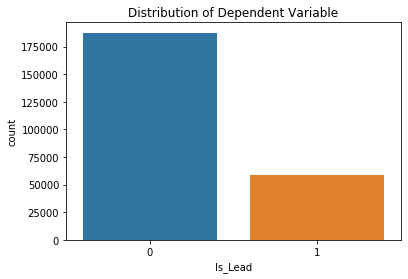

In [47]:
_ = sns.countplot(train['Is_Lead'])
plt.title('Distribution of Dependent Variable');

We can see that around 23.7% of the customers have expressed interest in the offering and 76.2% of the customers have not. The dependent variable is not highly imbalanced althoug there is slight imbalance in the data. 

In [48]:
# separating categorical and numerical columns
cat_cols = [col for col in df.columns if ((df[col].dtype=="object")&(col!="ID"))]
num_cols = [col for col in df.columns if col not in cat_cols+["ID"]]
print ("Categorical Columns are:{}".format(cat_cols))
print ("Numerical Columns are:{}".format(num_cols))

Categorical Columns are:['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
Numerical Columns are:['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead']


#### Dependent Variable - Univariate Analysis

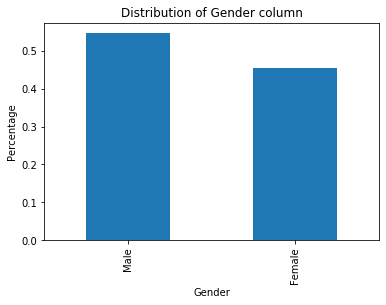

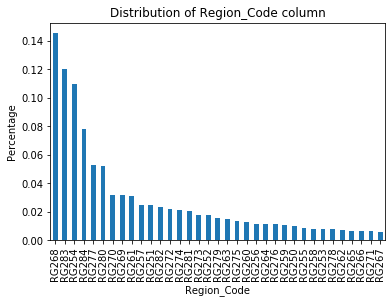

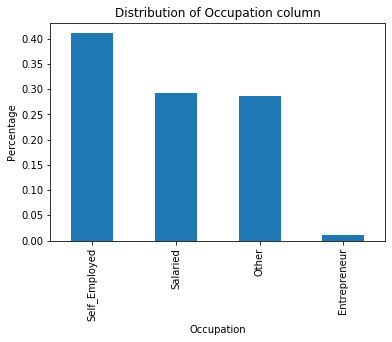

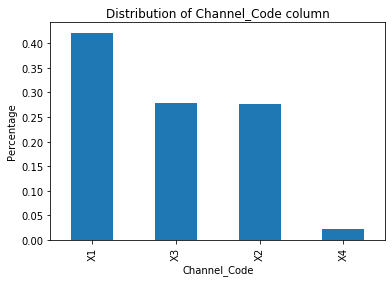

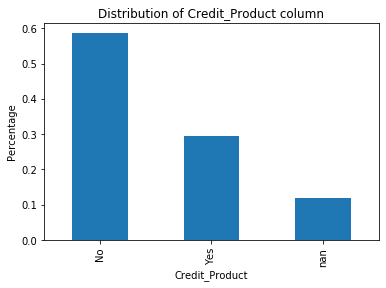

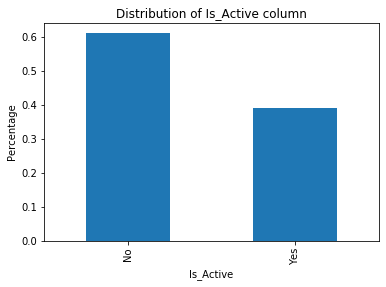

In [49]:
def categorical_plots(df,columns):
    # This function basically creates the countplot of all categorical variables.
    # columns should be a list of categorical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        df[col].value_counts(dropna=False,normalize=True).plot.bar();
        plt.title("Distribution of {} column".format(col));
        plt.xlabel(col);
        plt.ylabel("Percentage");
        plt.xticks(rotation=90);
categorical_plots(df,cat_cols)

**Observations**
1. There is almost equal distribution in Male and Female customers, altough Male customers are slightly higher in number.
2. region_code column has high cardinality, like we had already seen above. Some of the regions hae high customers as compared to other regions. 
3. Most of the customers are Self-Employed with very few Entrepreneurs. 
4. X1 seems to be a preferred Acquisition channel and X4 seems to be least.
5. credit_product has missing values as we had already seen above, apart from this, most of the customers do not have an active credit product with the bank.
6. Around 60% of the customers have not been active in the last 3 months. 

#### Bi-Variate Analysis, Categorical Variables - Target

<Figure size 432x288 with 0 Axes>

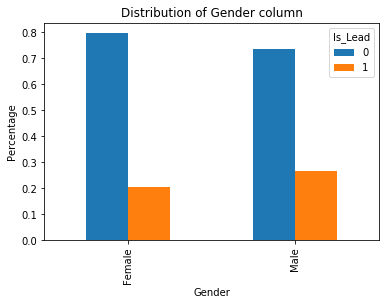

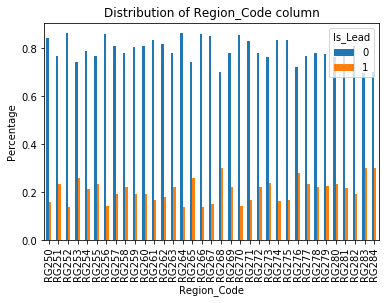

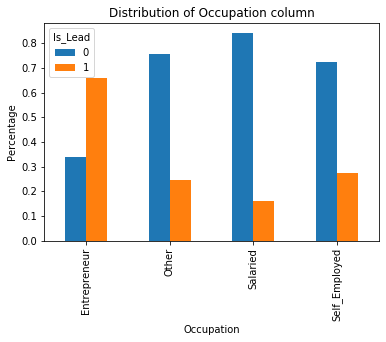

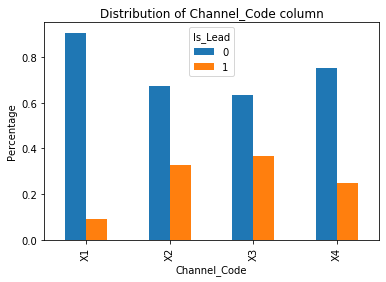

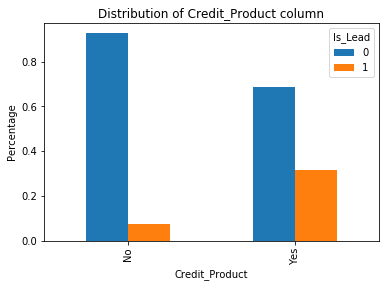

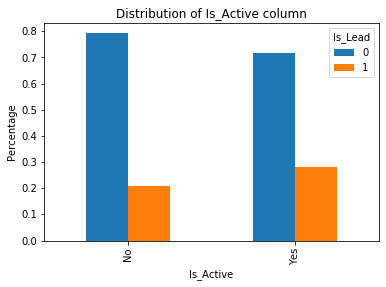

In [50]:
def categorical_plots(df,columns):
    # This function basically creates the countplot of all categorical variables.
    # columns should be a list of categorical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        df.groupby(col)['Is_Lead'].value_counts(normalize=True).unstack().plot(kind='bar');
        plt.title("Distribution of {} column".format(col));
        plt.xlabel(col);
        plt.ylabel("Percentage");
        plt.xticks(rotation=90);
categorical_plots(train,cat_cols)

**Observations**
1. We can observe that Entrepreneurs have a higher chance of Subscribing to the offer, this is contrary to all the plots above. This may also be attributed to the fact that the count of Entrepreneurs is low.

#### Numerical Feature Univariate Analysis - Distribution plots

<Figure size 432x288 with 0 Axes>

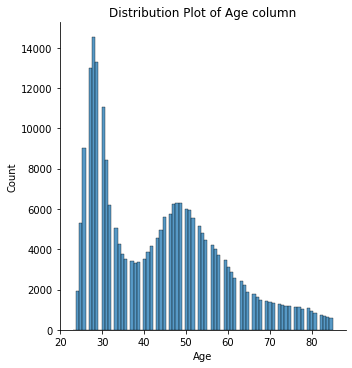

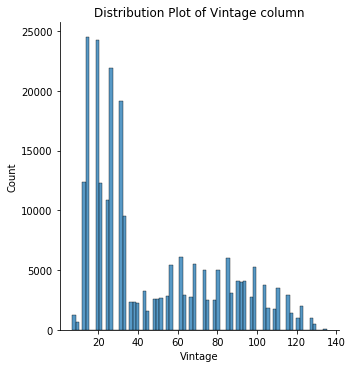

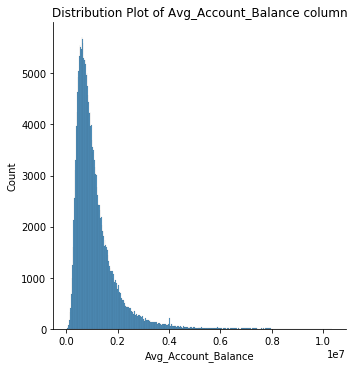

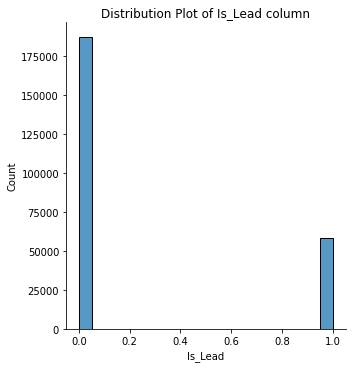

In [51]:
def distribution_plots(df,columns):
    # This small function basically creates the distribution plot of all numerical variables.
    # columns should be a list of numerical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        sns.displot(df[col],kde=False);
        plt.title("Distribution Plot of {} column".format(col));
        plt.xlabel(col);
distribution_plots(train,num_cols)

**Observations**
1. Average Balance is positively skewed which is expected because very few people will have high balances and most people will have low to medium balance.
2. Maximum values of the Vintage variable seems to be between 0 and 40. 
3. 25 to 35 seems to be majorit age group among the customers. 

In [52]:
Q1 = train['Avg_Account_Balance'].quantile(0.25)
Q3 = train['Avg_Account_Balance'].quantile(0.75)
IQR = Q3-Q1
print ("Values above {} and Values below {} can be considered as outliers".format(Q3+1.5*IQR,Q1-1.5*IQR))

Values above 2510200.0 and Values below -539224.0 can be considered as outliers


#### Numerical Feature Univariate Analysis - Box Plots

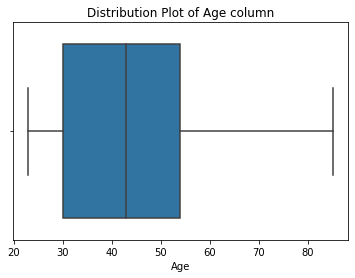

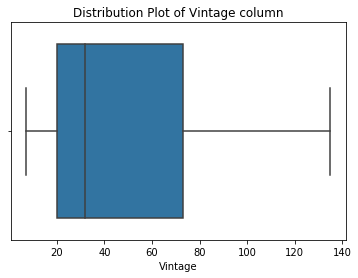

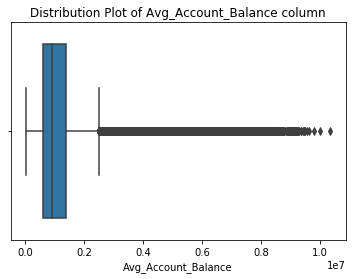

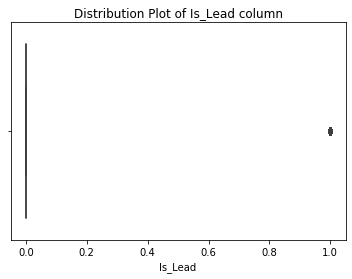

In [53]:
def box_plots(df,columns):
    # This small function basically creates the distribution plot of all numerical variables.
    # columns should be a list of numerical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        sns.boxplot(df[col]);
        plt.title("Distribution Plot of {} column".format(col));
        plt.xlabel(col);
box_plots(train,num_cols)

**Observations**
1. Average Balance seems to have some outliers but none of the other variables have outliers. 

#### Bi-Variate KDE Plot - Numerical Variable Vs Target

In [54]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [55]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


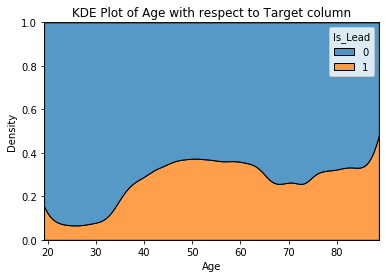

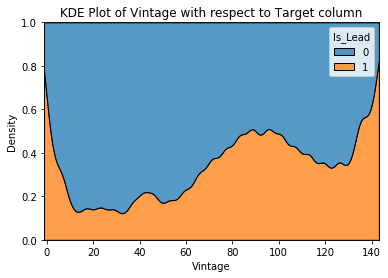

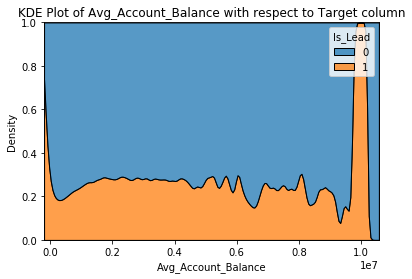

In [56]:
def distribution_plots(df,columns):
    # This small function basically creates the distribution plot of all numerical variables.
    # columns should be a list of numerical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        sns.kdeplot(data=df,x=col,hue='Is_Lead',multiple='fill');
        plt.title("KDE Plot of {} with respect to Target column".format(col));
        plt.xlabel(col);
distribution_plots(train,['Age','Vintage','Avg_Account_Balance'])

**Observations**
1. We can see that customers below the age of 30 have minimal chance of subscribing to the offer. Ages 45-60 have the same chance of subscribing to the offer, Ages above 80 have higher chance (this might be attributed to the fact that there are few customers above 80 and most of them have subscribed to the offer).
2. Customers who have been with the Bank for more than 125 months have higher chance of subscribing , so do new customers. Customers who have been with the bank between 80-100 months also have decent chance of subscribing to the offer. 
3. Customers with low balance and very high balance have good chance of subscribing to the offer, otherwise the probability of subscribing remains constant. 

#### Bivariate Analysis - Horizontal Bar Plots

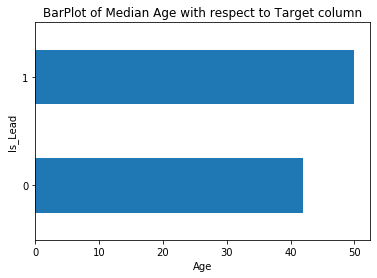

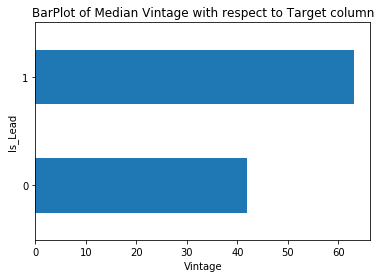

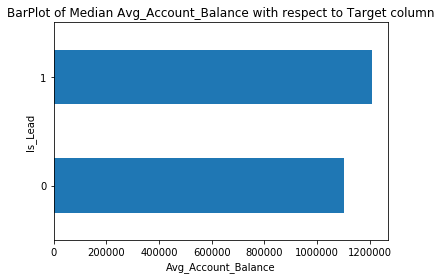

In [57]:
def distribution_plots(df,columns):
    # This small function basically creates the distribution plot of all numerical variables.
    # columns should be a list of numerical variables.
    for ind,col in enumerate(columns):
        plt.figure(ind);
        df.groupby('Is_Lead')[col].mean().plot.barh();
        plt.title("BarPlot of Median {} with respect to Target column".format(col));
        plt.xlabel(col);
distribution_plots(train,['Age','Vintage','Avg_Account_Balance'])

**Observations**
1. We can see that the Mean Age of customers who have subscribed to the offer is higher.
2. We can see that the Mean Vintage of customers who have subscribed to the offer is higher.
3. We can see that the Mean Avg_Account_Balance of customers who have subscribed to the offer is higher (although not substantially higher).

#### Correlations

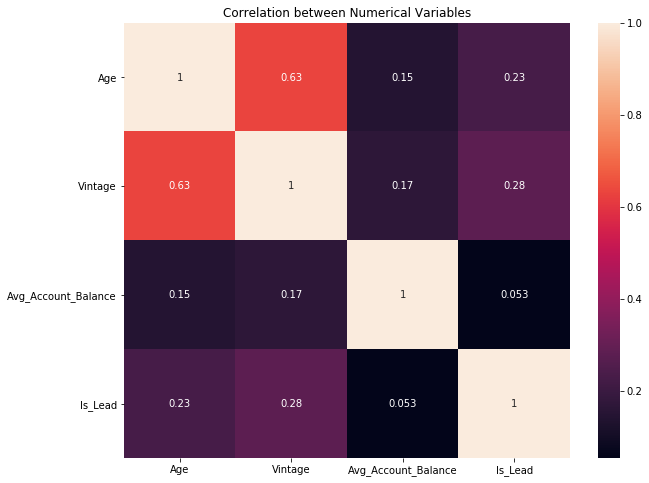

In [58]:
plt.figure(figsize=(10, 8));
plt.title("Correlation between Numerical Variables");
_ = sns.heatmap(train[num_cols].corr(), annot=True)

**Observations**
1. We can see that none of the variables are highly correlated to the dependent variable.
2. We can see that Vintage is related to Age variable although the correlation is not that high. 

In [59]:
df.isna().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
dtype: int64

In [60]:
# letting the model figure out the way to fill the missing values. 
# df['Credit_Product'].fillna("Missing",inplace=True)

#### Feature Generation

In [61]:
# creating frequency encoded feature
df['Region_Code'] = df['Region_Code'].map(df['Region_Code'].value_counts())


# creating groupby features
df['Mean_Avg_Account_Balance_Per_Occupation'] = df.groupby("Occupation")['Avg_Account_Balance'].transform('mean')
df['Median_Avg_Account_Balance_Per_Occupation'] = df.groupby("Occupation")['Avg_Account_Balance'].transform('median')
df['Min_Avg_Account_Balance_Per_Occupation'] = df.groupby("Occupation")['Avg_Account_Balance'].transform('min')
df['Max_Avg_Account_Balance_Per_Occupation'] = df.groupby("Occupation")['Avg_Account_Balance'].transform('max')

df['Mean_Avg_Account_Balance_Per_Channel_Code'] = df.groupby("Channel_Code")['Avg_Account_Balance'].transform('mean')
df['Median_Avg_Account_Balance_Per_Channel_Code'] = df.groupby("Channel_Code")['Avg_Account_Balance'].transform('median')
df['Min_Avg_Account_Balance_Per_Channel_Code'] = df.groupby("Channel_Code")['Avg_Account_Balance'].transform('min')
df['Max_Avg_Account_Balance_Per_Channel_Code'] = df.groupby("Channel_Code")['Avg_Account_Balance'].transform('max')

df['Mean_Avg_Account_Balance_Per_Credit_Product'] = df.groupby("Credit_Product")['Avg_Account_Balance'].transform('mean')
df['Median_Avg_Account_Balance_Per_Credit_Product'] = df.groupby("Credit_Product")['Avg_Account_Balance'].transform('median')
df['Min_Avg_Account_Balance_Per_Credit_Product'] = df.groupby("Credit_Product")['Avg_Account_Balance'].transform('min')
df['Max_Avg_Account_Balance_Per_Credit_Product'] = df.groupby("Credit_Product")['Avg_Account_Balance'].transform('max')

# Label Encoding
cat_cols = [col for col in df.columns if ((df[col].dtype=="object")&(col!="ID"))]
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

#### Splitting data into train and test

In [62]:
# splitting back to train and test
train_rf, test_rf = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_rf.columns if c not in ["ID", "Is_Lead"]]

# defining ID and target columns
ID_COL = "ID"
TARGET_COL = "Is_Lead"

# dropping unnecessary columns
test_rf.drop(['Is_Lead','ID'],axis=1,inplace=True)
train_rf.drop("ID",axis=1,inplace=True)

# checking the shape of the dataset
print (train_rf.shape)
print (test_rf.shape)

(245725, 22)
(105312, 21)


In [63]:
train_rf.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Mean_Avg_Account_Balance_Per_Occupation,Median_Avg_Account_Balance_Per_Occupation,Min_Avg_Account_Balance_Per_Occupation,Max_Avg_Account_Balance_Per_Occupation,Mean_Avg_Account_Balance_Per_Channel_Code,Median_Avg_Account_Balance_Per_Channel_Code,Min_Avg_Account_Balance_Per_Channel_Code,Max_Avg_Account_Balance_Per_Channel_Code,Mean_Avg_Account_Balance_Per_Credit_Product,Median_Avg_Account_Balance_Per_Credit_Product,Min_Avg_Account_Balance_Per_Credit_Product,Max_Avg_Account_Balance_Per_Credit_Product
0,0,73,51059,0,0,43,0,1045696,0,0.00000,1211035.40307,959811.00000,20790,10352009,1277796.86648,1034313.00000,44856,10352009,1081144.96555,845517.00000,20790.00000,9908858.00000
1,0,30,18422,1,1,32,0,581988,0,0.00000,1036457.10687,812636.50000,45950,9701151,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000
2,0,56,51059,2,0,26,0,1484315,1,0.00000,1133054.65998,909352.50000,22597,8762071,1277796.86648,1034313.00000,44856,10352009,1081144.96555,845517.00000,20790.00000,9908858.00000
3,1,34,11160,1,1,19,0,470454,0,0.00000,1036457.10687,812636.50000,45950,9701151,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000
4,0,30,8166,1,1,33,0,886787,0,0.00000,1036457.10687,812636.50000,45950,9701151,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000


In [64]:
test_rf.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Mean_Avg_Account_Balance_Per_Occupation,Median_Avg_Account_Balance_Per_Occupation,Min_Avg_Account_Balance_Per_Occupation,Max_Avg_Account_Balance_Per_Occupation,Mean_Avg_Account_Balance_Per_Channel_Code,Median_Avg_Account_Balance_Per_Channel_Code,Min_Avg_Account_Balance_Per_Channel_Code,Max_Avg_Account_Balance_Per_Channel_Code,Mean_Avg_Account_Balance_Per_Credit_Product,Median_Avg_Account_Balance_Per_Credit_Product,Min_Avg_Account_Balance_Per_Credit_Product,Max_Avg_Account_Balance_Per_Credit_Product
0,1,29,38577,0,1,25,1,742366,0,1211035.40307,959811.00000,20790,10352009,1033424.82917,808280.00000,22597,10007678,1188067.45141,955308.00000,45950.00000,10352009.00000
1,1,43,51059,0,2,49,-1,925537,0,1211035.40307,959811.00000,20790,10352009,1141920.31953,920335.50000,20790,9878021,nan,nan,nan,nan
2,1,31,11160,1,1,14,0,215949,0,1036457.10687,812636.50000,45950,9701151,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000
3,1,29,7590,0,1,33,0,868070,0,1211035.40307,959811.00000,20790,10352009,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000
4,0,29,11160,0,1,19,0,657087,0,1211035.40307,959811.00000,20790,10352009,1033424.82917,808280.00000,22597,10007678,1081144.96555,845517.00000,20790.00000,9908858.00000


In [65]:
X = train_rf[features]
y = train_rf['Is_Lead']

#### Defining CV function

In [66]:
def run_cross_validation(clf,fit_params,train,test,features):
    
    # defining the number of splits
    NSPLITS = 5
    
    # generating dummy predictions for test data and out of fold data
    predictions = np.zeros(test.shape[0])
    oofs        = np.zeros(train.shape[0])
    
    # defining an empty list to collect the roc_auc score of each fold
    roc_score   = []
    
    # defining te criteria of split
    folds       = StratifiedKFold(n_splits=NSPLITS,random_state=42,shuffle=True)
    
    # Cross Validation
    for fold_, (train_index,test_index) in enumerate(folds.split(train[features],train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')
        
        # dividing the data into folds
        x_train, x_val = train[features].iloc[train_index], train[features].iloc[test_index]
        y_train, y_val = train[TARGET_COL].iloc[train_index], train[TARGET_COL].iloc[test_index]
        
        # fitting the model
        _ = clf.fit(x_train, 
                    y_train, 
                    eval_set = [(x_val, y_val)], 
                    **fit_params, 
                    eval_metric=['auc'])
        
        
        # predicting on validation data and appending the score to roc_score list
        preds = clf.predict_proba(x_val)[:, 1]
        score = roc_auc_score(y_val,preds)
        print ("Validation ROC AUC Score:",score)
        print ("------------------------------------------------")
        roc_score.append(score)
        
        # oofs predictions
        oofs[test_index] = preds
    
        # Predicting on the test set
        predictions += clf.predict_proba(test)[:, 1] / folds.n_splits
    
    
    # plotting Feature Importance
    plt.figure(figsize=(6,8));
    ser = pd.Series(clf.feature_importances_,test.columns).sort_values();
    ser.plot(kind='barh');
    plt.title("Feature Importance Plot");
    plt.xlabel("Feature");
    plt.ylabel("Importance");
    
    # Mean roc_score of 5 folds. 
    print ("------------------------------------------")
    print ("Mean ROC AUC Score of 5 Folds:",np.mean(np.array(roc_score)))
    
    return oofs, predictions 

#### LightGBM Model


------------- Fold 1 -------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.874901	valid_0's binary_logloss: 0.410076
Validation ROC AUC Score: 0.8749007980858182
------------------------------------------------

------------- Fold 2 -------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.870986	valid_0's binary_logloss: 0.411272
Validation ROC AUC Score: 0.8709859025867088
------------------------------------------------

------------- Fold 3 -------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.872025	valid_0's binary_logloss: 0.409428
Validation ROC AUC Score: 0.8720248135153829
------------------------------------------------

------------- Fold 4 -------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.873392	valid_0's binary_logloss: 0.40963
Validation ROC AUC Score: 0.8733922309971442
------------------------------------------------

------------- Fold 5 -------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.873139	valid_0's binary_logloss: 0.40929
Validation ROC AUC Score: 0.8731392754612071
------------------------------------------------
------------------------------------------
Mean ROC AUC Score of 5 Folds: 0.8728886041292523


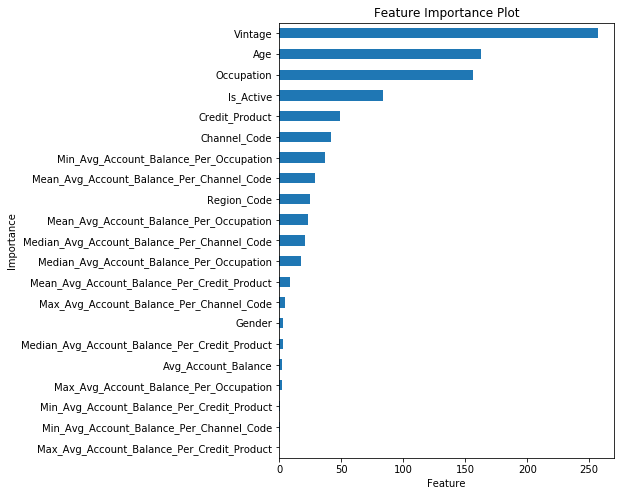

In [67]:
# defining the parameters of the model
clf = lgb.LGBMClassifier(objective='binary',
                         n_jobs=-1,
                         boosting_type="gbdt",
                         learning_rate=0.05,
                         n_estimators=2000,
                         colsample_bytree=0.75,
                         subsample=0.9,
                         is_unbalance="True")

# defining other parameters
fit_params = {'verbose': 100, 'early_stopping_rounds': 50, 'categorical_feature':cat_cols}

# running the CV framework
lgb_oofs, lgb_preds = run_cross_validation(clf, fit_params, train_rf,test_rf,features)

Text(0.5, 0, 'False positive rate')

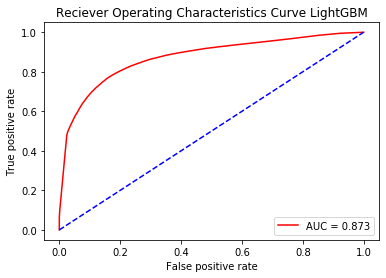

In [68]:
# plotting the ROC curve for LightGBM model
frp,trp, threshold = roc_curve(y,lgb_oofs)
roc_auc_ = auc(frp,trp)
plt.title('Reciever Operating Characteristics Curve LightGBM')
plt.plot(frp,trp,'r',label = 'AUC = %0.3f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

#### XGBoost Model


------------- Fold 1 -------------
[0]	validation_0-auc:0.85514
Will train until validation_0-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.87556
Stopping. Best iteration:
[138]	validation_0-auc:0.87567

Validation ROC AUC Score: 0.8756648709040098
------------------------------------------------

------------- Fold 2 -------------
[0]	validation_0-auc:0.85137
Will train until validation_0-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.87232
[200]	validation_0-auc:0.87250
Stopping. Best iteration:
[209]	validation_0-auc:0.87253

Validation ROC AUC Score: 0.8725309716563763
------------------------------------------------

------------- Fold 3 -------------
[0]	validation_0-auc:0.85325
Will train until validation_0-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.87313
[200]	validation_0-auc:0.87352
Stopping. Best iteration:
[152]	validation_0-auc:0.87365

Validation ROC AUC Score: 0.8736542730020942
------------------------------------------------

-

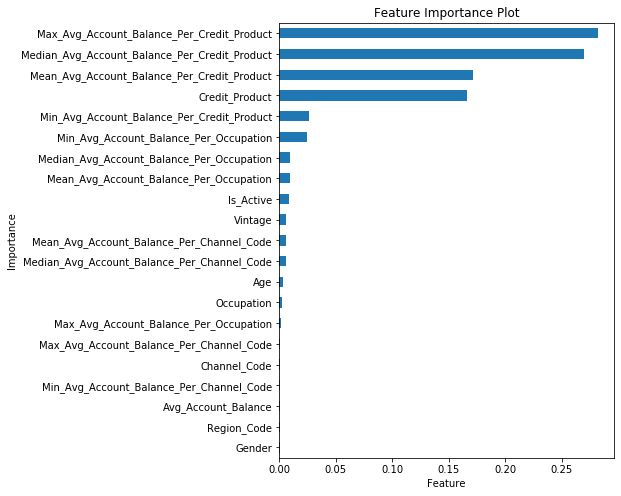

In [69]:
# defining the parameters of the model
clf = xgb.XGBClassifier(objective='binary:logistic',
                        n_jobs=-1,
                        boosting_type="gbdt",
                        learning_rate=0.05,
                        n_estimators=2000,
                        colsample_bytree=0.75,
                        subsample=0.9,
                        random_state=42,
                        class_weight='balanced')

# defining other parameters
fit_params = {'verbose': 100, 'early_stopping_rounds': 50}

# running the CV framework
xgb_oofs, xgb_preds = run_cross_validation(clf, fit_params, train_rf,test_rf,features)

Text(0.5, 0, 'False positive rate')

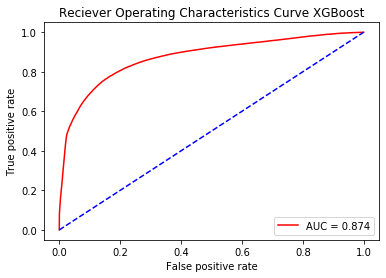

In [70]:
# plotting the ROC curve for XGBoost model
frp,trp, threshold = roc_curve(y,xgb_oofs)
roc_auc_ = auc(frp,trp)
plt.title('Reciever Operating Characteristics Curve XGBoost')
plt.plot(frp,trp,'r',label = 'AUC = %0.3f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

#### Ensembling

In [71]:
# defining new dataframes with target columns
train_ensemble = train[[TARGET_COL]]
test_ensemble  = test[[]]

train_ensemble['lgb_predictions'] = lgb_oofs
test_ensemble['lgb_predictions']  = lgb_preds

train_ensemble['xgb_predictions'] = xgb_oofs
test_ensemble['xgb_predictions']  = xgb_preds

new_features = [c for c in train_ensemble.columns if c not in [ID_COL, TARGET_COL]]

In [72]:
train_ensemble.head()

,Is_Lead,lgb_predictions,xgb_predictions
0,0,0.16793,0.03984
1,0,0.17023,0.05658
2,0,0.19917,0.06553
3,0,0.16785,0.05408
4,0,0.17016,0.05643


In [73]:
test_ensemble.head()

,lgb_predictions,xgb_predictions
0,0.15591,0.04592
1,0.80026,0.88839
2,0.16876,0.05877
3,0.10428,0.02373
4,0.10428,0.02211


In [74]:
new_features

['lgb_predictions', 'xgb_predictions']


------------- Fold 1 -------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.875935	valid_0's binary_logloss: 0.383258
Validation ROC AUC Score: 0.8759351973215341
------------------------------------------------

------------- Fold 2 -------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.87246	valid_0's binary_logloss: 0.351159
Validation ROC AUC Score: 0.8724595879717568
------------------------------------------------

------------- Fold 3 -------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.873508	valid_0's binary_logloss: 0.371549
Validation ROC AUC Score: 0.8735083128697858
------------------------------------------------

------------- Fold 4 -------------
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.874747	vali

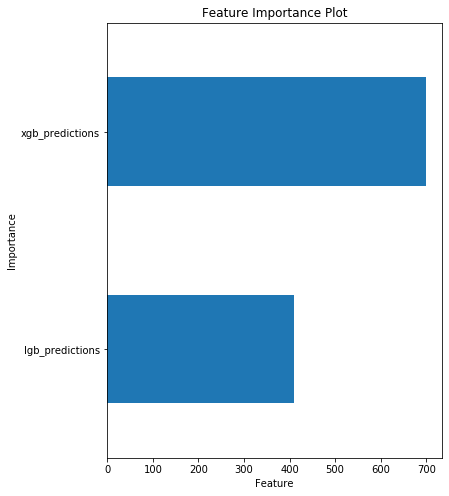

In [75]:
# Running the ensemble model of LightGBM and XGBoost
clf = lgb.LGBMClassifier(objective='binary',
                         n_jobs=-1,
                         boosting_type="gbdt",
                         learning_rate=0.05,
                         n_estimators=2000,
                         colsample_bytree=0.75,
                         subsample=0.9,
                         random_state=42)

fit_params = {'verbose': 100, 'early_stopping_rounds': 50 }
ensemble_oofs, ensemble_pred = run_cross_validation(clf, fit_params, train_ensemble, test_ensemble, new_features)

#### Final Submission

In [76]:
Submission['Is_Lead'] = ensemble_pred
Submission.to_csv(r"C:\Users\kulka\Desktop\AV_Hackathon_Codes\Jobathon2\Submissions\Ensemble_9.csv",index=None)

In [77]:
Submission.head()

,ID,Is_Lead
0,VBENBARO,0.08735
1,CCMEWNKY,0.75096
2,VK3KGA9M,0.08887
3,TT8RPZVC,0.06536
4,SHQZEYTZ,0.06463
